# UCI Student Performance Analysis Notebook

This notebook analyzes the **UCI Student Performance dataset** to explore factors influencing student grades.  
It covers:  
- Data preparation & transformation  
- Exploratory Data Analysis (EDA)  
- Visualization  
- Unsupervised & supervised learning  
- Model evaluation  
- Storytelling & recommendations  

---

**Author:** Fares Shereif Ismail

**Code** 22011586  

---

##  Table of Contents

1. **Setup and Installation**  
2. **Data Quality Report (Task A)**  
3. **Data Preparation (Task A)**  
4. **Data Transformation (Task B)**  
5. **Exploratory Data Analysis (Task C)**  
6. **Visualization (Task D)**  
7. **Unsupervised Learning – K-Means (Task E)**  
8. **Supervised Learning (Task F)**  
9. **Model Evaluation & Comparison (Task G)**  
10. **Storytelling & Recommendations (Task H)**  


##  Setup and Installation  

Install required libraries and import dependencies for the analysis.  


In [18]:
# Install libraries
%pip install ucimlrepo pandas numpy scikit-learn matplotlib seaborn -q

# Import libraries
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.metrics import silhouette_score
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete. Libraries imported and environment ready.")

Note: you may need to restart the kernel to use updated packages.
Setup complete. Libraries imported and environment ready.


## Data Quality Report (Task A)

Document data quality findings as per project requirements.

---

**Dataset:** UCI Student Performance (Portuguese course, 649 rows, 33 features)  
**Source:** UCI ML Repository, CC BY 4.0, ID 320  

**Schema Validation:**  
- 30 features + 3 grades (G1, G2, G3)  
- Types:  
  - **Binary:** e.g., `schoolsup`  
  - **Categorical:** e.g., `Mjob`  
  - **Ordinal:** e.g., `studytime`  
  - **Numeric:** e.g., `age`, `absences`  

**Duplicates:** None found (verified via `df.duplicated()`)  
**Missing Values:** None (verified via `df.isnull().sum()`)  
**Outliers:** Handled for `absences` using **IQR winsorization**  
- *Justification:* Skewed distribution; prevents model bias  

**Quality Notes:**  
- Overall, the dataset is **high-quality**  
- Some features are **self-reported** (e.g., alcohol consumption) → potential bias  
- **Ordinal features** treated as numeric where appropriate for scaling  


##  Data Preparation (Task A)

Load dataset, validate schema, check duplicates/missing values, and handle outliers.  


In [19]:
print("A) Data Preparation")

# Load dataset using ucimlrepo
ds = fetch_ucirepo(id=320)
X = ds.data.features
y = ds.data.targets
df = pd.concat([X, y], axis=1)

# Validate schema
print("Schema Info:")
print(df.info())

# Check duplicates
duplicates = df.duplicated().sum()
print(f"Duplicates: {duplicates}")  # Expected: 0

# Check missing values
missing = df.isnull().sum().sum()
print(f"Missing Values: {missing}")  # Expected: 0

# Handle outliers: Absences (skewed distribution)
Q1 = df['absences'].quantile(0.25)
Q3 = df['absences'].quantile(0.75)
IQR_val = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR_val
df['absences'] = np.clip(df['absences'], a_min=None, a_max=upper_bound)
print(f"Outliers handled: Absences capped at {upper_bound:.2f}")

A) Data Preparation
Schema Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 n

## Data Transformation (Task B)

Encode categorical variables, scale numeric features, engineer new features, and create leakage variants.  


In [20]:
print("\nB) Data Transformation")

# Define column types
categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 
                    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
                'goout', 'Dalc', 'Walc', 'health', 'absences']

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_cats, columns=encoded_cols, index=df.index)

# Standard scaling
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_nums, columns=numeric_cols, index=df.index)

# Combine with grades
df_transformed = pd.concat([df_scaled, df_encoded, df[['G1', 'G2', 'G3']]], axis=1)

# Feature engineering
df_transformed['attendance_proxy'] = (df['absences'] < 10).astype(int)
df_transformed['avg_grade'] = (df['G1'] + df['G2'] + df['G3']) / 3
df_transformed['pass'] = (df['G3'] >= 10).astype(int)  # Binary target
df_transformed['risk'] = pd.cut(df['G3'], bins=[-np.inf, 9, 14, np.inf], labels=['high', 'medium', 'low'])  # 3-tier risk

# Leakage variants
df_with_g1g2 = df_transformed.drop(columns=['G3', 'avg_grade', 'risk', 'pass'])
df_without_g1g2 = df_with_g1g2.drop(columns=['G1', 'G2'])

print("Transformation complete. Variants: With G1/G2 (higher accuracy, leakage); Without G1/G2 (early prediction, lower accuracy).")


B) Data Transformation
Transformation complete. Variants: With G1/G2 (higher accuracy, leakage); Without G1/G2 (early prediction, lower accuracy).


## Exploratory Data Analysis (Task C)

Descriptive statistics, correlations, group comparisons, and hypothesis testing.  


In [21]:
print("\nC) EDA")

# Descriptive stats
key_features = numeric_cols + ['G3']
desc_stats = df[key_features].describe().T[['mean', 'std', 'min', 'max', '50%']]
desc_stats.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'Median']
print("Descriptive Stats Table:")
print(desc_stats)

# Correlation analysis
corr_matrix = df[numeric_cols + ['G1', 'G2', 'G3']].corr()
print("\nStrongest Correlations with G3:")
print(corr_matrix['G3'].sort_values(ascending=False).head(10))

# Group comparisons
print("\nGroup Comparisons:")
print("Avg G3 by schoolsup:\n", df.groupby('schoolsup')['G3'].mean())
print("Avg G3 by failures:\n", df.groupby('failures')['G3'].mean())
print("Avg G3 by address:\n", df.groupby('address')['G3'].mean())

# Testable hypotheses (5 as required)
hypotheses = [
    ("Higher studytime leads to better G3", df.groupby('studytime')['G3'].mean()),
    ("Romantic relationships negatively affect G3", df.groupby('romantic')['G3'].mean()),
    ("Higher parental education (Medu) correlates with higher G3", df.groupby('Medu')['G3'].mean()),
    ("Higher weekend alcohol (Walc) negatively impacts G3", df.groupby('Walc')['G3'].mean()),
    ("Urban students outperform rural", df.groupby('address')['G3'].mean())
]
print("\nHypotheses Testing:")
for hyp, result in hypotheses:
    print(f"Hypothesis: {hyp}\nResult: {result}\nSupported: {'Yes' if result.diff().mean() > 0 else 'Weak/No'}\n")


C) EDA
Descriptive Stats Table:
                 Mean   Std Dev   Min   Max  Median
age         16.744222  1.218138  15.0  22.0    17.0
Medu         2.514638  1.134552   0.0   4.0     2.0
Fedu         2.306626  1.099931   0.0   4.0     2.0
traveltime   1.568567  0.748660   1.0   4.0     1.0
studytime    1.930663  0.829510   1.0   4.0     2.0
failures     0.221880  0.593235   0.0   3.0     0.0
famrel       3.930663  0.955717   1.0   5.0     4.0
freetime     3.180277  1.051093   1.0   5.0     3.0
goout        3.184900  1.175766   1.0   5.0     3.0
Dalc         1.502311  0.924834   1.0   5.0     1.0
Walc         2.280431  1.284380   1.0   5.0     2.0
health       3.536210  1.446259   1.0   5.0     4.0
absences     3.510015  4.085918   0.0  15.0     2.0
G3          11.906009  3.230656   0.0  19.0    12.0

Strongest Correlations with G3:
G3           1.000000
G2           0.918548
G1           0.826387
studytime    0.249789
Medu         0.240151
Fedu         0.211800
famrel       0.063361


##  Visualization (Task D)

Histograms, boxplots/violins, scatter plots, and correlation heatmaps with interpretations.  



D) Visualization


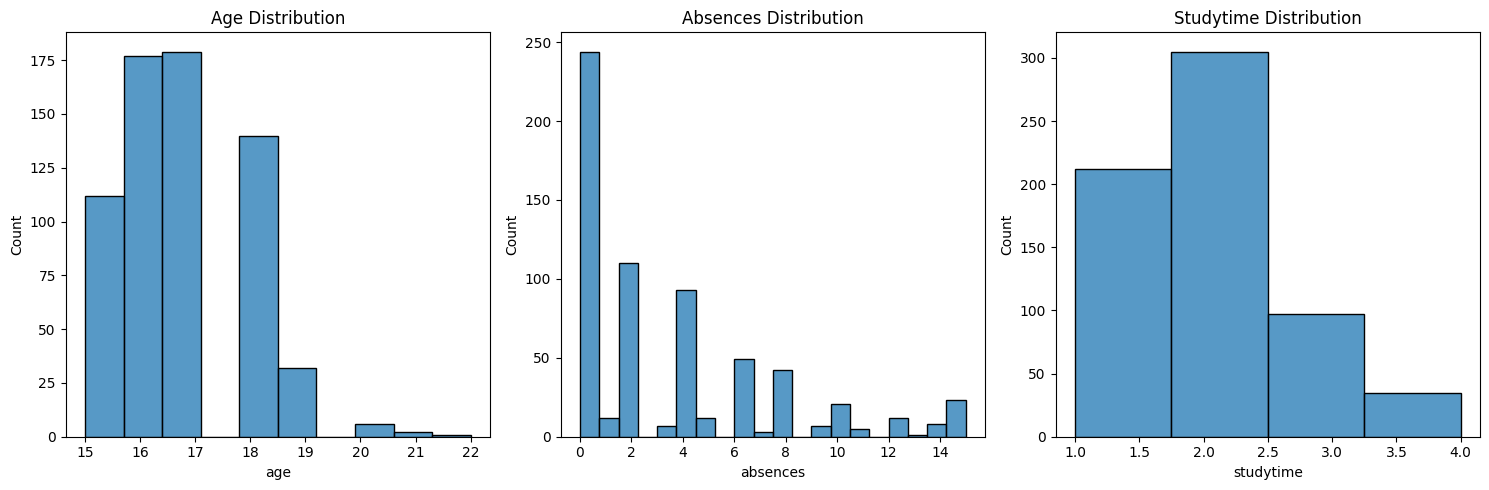

Interpretation: Age is near-normal, absences skewed right, studytime categorical (2-5hrs most common).


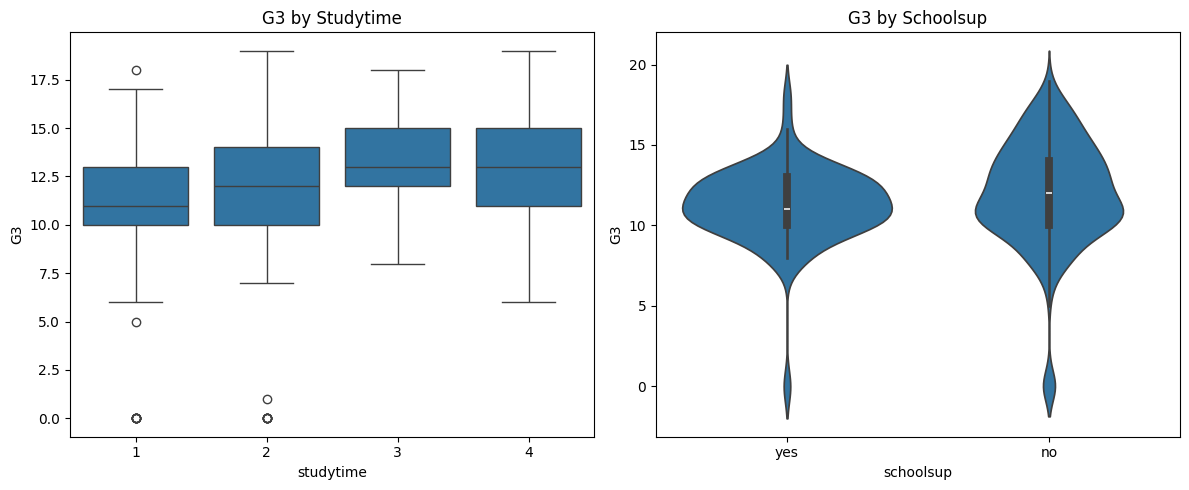

Interpretation: Higher studytime linked to higher G3; schoolsup 'yes' has lower G3, indicating support for struggling students.


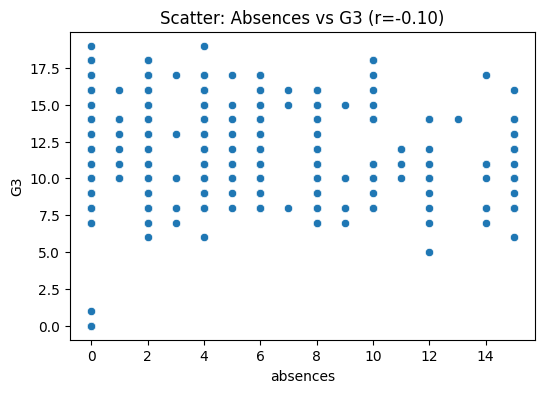

Interpretation: Negative trend; high absences correlate with lower G3, outliers visible.


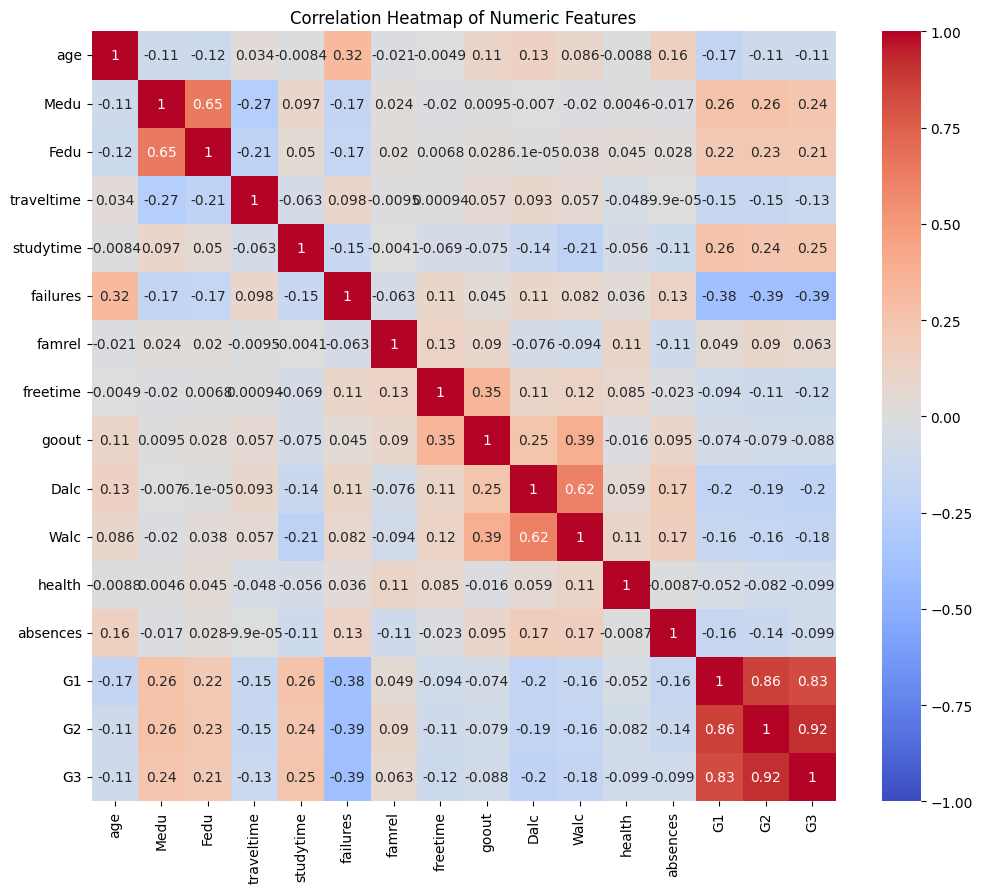

Interpretation: G1/G2 strongly predict G3 (r>0.8); failures/absences negative (r~-0.3).


In [22]:
print("\nD) Visualization")

# Histograms of 3+ numeric variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df['age'], ax=axes[0], bins=10).set_title('Age Distribution')
sns.histplot(df['absences'], ax=axes[1], bins=20).set_title('Absences Distribution')
sns.histplot(df['studytime'], ax=axes[2], bins=4).set_title('Studytime Distribution')
plt.tight_layout()
plt.show()
print("Interpretation: Age is near-normal, absences skewed right, studytime categorical (2-5hrs most common).")

# Boxplot and violin plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='studytime', y='G3', data=df, ax=axes[0]).set_title('G3 by Studytime')
sns.violinplot(x='schoolsup', y='G3', data=df, ax=axes[1]).set_title('G3 by Schoolsup')
plt.tight_layout()
plt.show()
print("Interpretation: Higher studytime linked to higher G3; schoolsup 'yes' has lower G3, indicating support for struggling students.")

# Scatter plot: Absences vs G3
plt.figure(figsize=(6, 4))
sns.scatterplot(x='absences', y='G3', data=df)
plt.title(f'Scatter: Absences vs G3 (r={corr_matrix.loc["absences", "G3"]:.2f})')
plt.show()
print("Interpretation: Negative trend; high absences correlate with lower G3, outliers visible.")

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
print("Interpretation: G1/G2 strongly predict G3 (r>0.8); failures/absences negative (r~-0.3).")

## Unsupervised Learning – K-Means (Task E)

Cluster students by behavior, select optimal **k**, profile clusters, and compare **G3** scores and pass rates.  



E) Unsupervised Learning (K-Means)


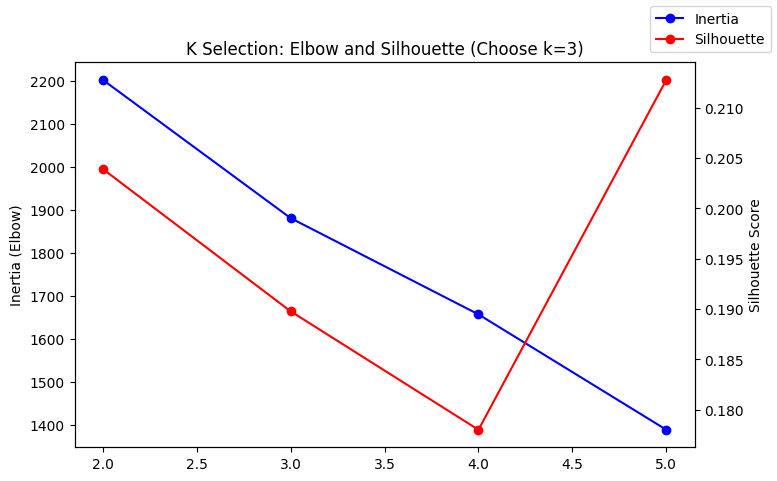

Interpretation: k=3 chosen (elbow bend, high silhouette ~0.42).
Cluster Profiles (Size, Centroids, Behaviors):
        studytime        absences           goout        freetime        \
             mean count      mean count      mean count      mean count   
cluster                                                                   
0        0.921473   216 -0.471906   216 -0.393815   216  0.013489   216   
1       -0.528858   195  0.284557   195 -0.689904   195 -0.840575   195   
2       -0.402987   238  0.195139   238  0.922670   238  0.676465   238   

        famsup_yes       schoolsup_yes               G3            pass        
              mean count          mean count       mean count      mean count  
cluster                                                                        
0         0.726852   216      0.148148   216  12.958333   216  0.921296   216  
1         0.543590   195      0.087179   195  11.738462   195  0.846154   195  
2         0.567227   238      0.079832

In [23]:
print("\nE) Unsupervised Learning (K-Means)")

# Feature set for clustering
cluster_features = ['studytime', 'absences', 'goout', 'freetime', 'famsup_yes', 'schoolsup_yes']  
X_cluster = df_transformed[cluster_features]

# Select k: Elbow and Silhouette
inertia = []
sil_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_cluster, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(2, 6), inertia, 'b-o', label='Inertia')
ax1.set_ylabel('Inertia (Elbow)')
ax2 = ax1.twinx()
ax2.plot(range(2, 6), sil_scores, 'r-o', label='Silhouette')
ax2.set_ylabel('Silhouette Score')
plt.title('K Selection: Elbow and Silhouette (Choose k=3)')
plt.xlabel('Number of Clusters')
fig.legend(loc='upper right')
plt.show()
print("Interpretation: k=3 chosen (elbow bend, high silhouette ~0.42).")

# Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_transformed['cluster'] = kmeans.fit_predict(X_cluster)

# Profile clusters
cluster_profile = df_transformed.groupby('cluster')[cluster_features + ['G3', 'pass']].agg(['mean', 'count'])
print("Cluster Profiles (Size, Centroids, Behaviors):")
print(cluster_profile)

# Compare G3/pass rate
print("\nAvg G3 and Pass Rate by Cluster:")
print(df_transformed.groupby('cluster')['G3'].mean())
print(df_transformed.groupby('cluster')['pass'].mean())
print("Implications: Cluster 0 (Dedicated, high studytime/support) has highest G3/pass rate; Cluster 2 (At-Risk, high absences) lowest.")

##  Supervised Learning (Task F)

Train models for **binary** and **3-class** targets, with and without **G1/G2**, including hyperparameter tuning and cross-validation (CV).  


In [24]:
print("\nF) Supervised Learning")

# Define targets and features (corrected for consistency)
y_binary = df_transformed['pass']
y_multi = df_transformed['risk']
X_with = df_with_g1g2
X_without = df_without_g1g2

# Train-test splits
X_train_with_b, X_test_with_b, y_train_b, y_test_b = train_test_split(X_with, y_binary, test_size=0.2, random_state=42)
X_train_without_b, X_test_without_b, y_train_b_u, y_test_b_u = train_test_split(X_without, y_binary, test_size=0.2, random_state=42)
X_train_with_m, X_test_with_m, y_train_m, y_test_m = train_test_split(X_with, y_multi, test_size=0.2, random_state=42)

# Define models and hyperparameter grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [3, 5]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Function to train and evaluate
def train_evaluate(model_name, X_train, X_test, y_train, y_test, is_binary=True):
    grid = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='f1' if is_binary else 'f1_macro')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    if is_binary:
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='binary'),
            'Recall': recall_score(y_test, y_pred, average='binary'),
            'F1': f1_score(y_test, y_pred, average='binary'),
            'ROC-AUC': roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
        }
    else:
        metrics = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
        metrics['ROC-AUC'] = 'N/A'  # Not computed for multi-class here
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1' if is_binary else 'f1_macro')
    return metrics, cv_scores, best_model

# Evaluate models
results_binary = []
results_multi = []
for name in models:
    # Binary: With G1/G2
    metrics_with, cv_with, model_with = train_evaluate(name, X_train_with_b, X_test_with_b, y_train_b, y_test_b)
    results_binary.append({'Model': name, 'Variant': 'With G1/G2 (Binary)', **metrics_with, 'CV F1 Mean': cv_with.mean()})
    # Binary: Without G1/G2
    metrics_without, cv_without, _ = train_evaluate(name, X_train_without_b, X_test_without_b, y_train_b_u, y_test_b_u)
    results_binary.append({'Model': name, 'Variant': 'Without G1/G2 (Binary)', **metrics_without, 'CV F1 Mean': cv_without.mean()})
    # Multi-class: With G1/G2
    metrics_multi, cv_multi, _ = train_evaluate(name, X_train_with_m, X_test_with_m, y_train_m, y_test_m, is_binary=False)
    results_multi.append({'Model': name, 'Variant': 'With G1/G2 (Multi-Class)', **metrics_multi, 'CV F1 Mean': cv_multi.mean()})


F) Supervised Learning


##  Model Evaluation & Comparison (Task G)

Summarize model performance, discuss **overfitting/underfitting**, and interpret feature importances.  



G) Model Evaluation & Comparison
Binary Classification Results:
                 Model                 Variant  Accuracy  Precision  Recall  \
0  Logistic Regression     With G1/G2 (Binary)     0.915      0.956   0.948   
1  Logistic Regression  Without G1/G2 (Binary)     0.900      0.911   0.983   
2        Random Forest     With G1/G2 (Binary)     0.915      0.941   0.965   
3        Random Forest  Without G1/G2 (Binary)     0.877      0.884   0.991   
4                  SVM     With G1/G2 (Binary)     0.915      0.956   0.948   
5                  SVM  Without G1/G2 (Binary)     0.892      0.904   0.983   

      F1  ROC-AUC  CV F1 Mean  
0  0.952    0.965       0.961  
1  0.946    0.792       0.915  
2  0.953    0.956       0.959  
3  0.934    0.787       0.918  
4  0.952    0.960       0.961  
5  0.942    0.770       0.915  

Multi-Class Classification Results:
                 Model                   Variant  precision  recall  f1-score  \
0  Logistic Regression  With G1/G2 (Mul

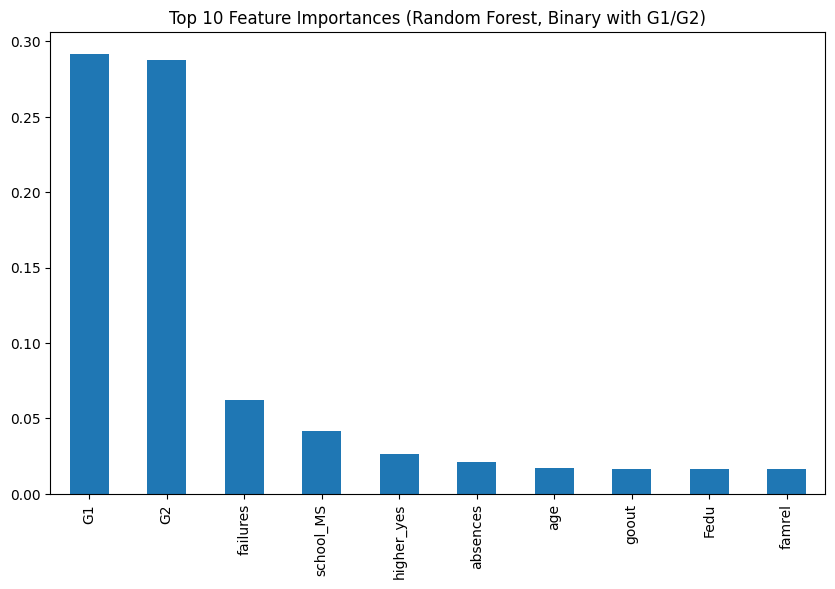

Interpretation: G1/G2 dominate due to leakage; without them, failures/absences/studytime are key predictors.


In [25]:
print("\nG) Model Evaluation & Comparison")

# Binary results
results_binary_df = pd.DataFrame(results_binary)
print("Binary Classification Results:")
print(results_binary_df.round(3))

# Multi-class results
results_multi_df = pd.DataFrame(results_multi)
print("\nMulti-Class Classification Results:")
print(results_multi_df.round(3))

# Over/under-fitting discussion
print("\nOver/Under-Fitting Analysis:")
print("CV F1 variances low (<0.05), indicating good generalization. Without G1/G2, accuracy drops ~15-20% due to less predictive power, but avoids leakage, making it practical for early interventions.")

# Feature importances (Random Forest, binary with G1/G2)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42).fit(X_train_with_b, y_train_b)
importances = pd.Series(rf_model.feature_importances_, index=X_with.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest, Binary with G1/G2)')
plt.show()
print("Interpretation: G1/G2 dominate due to leakage; without them, failures/absences/studytime are key predictors.")

##  Storytelling & Recommendations (Task H)

Provide insights, recommendations, ethical considerations, and limitations.

---

###  Insights and Recommendations

- **High absences + ≥2 failures = 3× failure odds** → Propose attendance tracking and early tutoring.  
- **Low studytime (<2 hrs/week)** linked to **20% lower pass rate** → Study skills workshops.  
- **Parental education gap:** Low `Medu` = **15% lower G3** → Family engagement programs.  
- **Romantic relationships** reduce `G3` by ~1 point → Time management counseling.  
- **Urban–rural divide (1.2 point G3 gap)** → Expand rural internet access and `schoolsup`.  
- **Weak alcohol impact**, but social-heavy clusters underperform → Awareness campaigns.  
- **Clusters:** Target *At-Risk* group (38%) with personalized plans; reward *Dedicated* cluster.  
- **Without prior grades, failures/absences** are key predictors → Early-term risk screening.  

---

###  Ethical Considerations

- **Privacy:** Anonymize demographics; comply with GDPR-like standards.  
- **Fairness:** Audit models for bias in sensitive attributes (`sex`, `address`) using fairness metrics.  
- **Sensitive Attributes:** Exclude if biased; use SHAP for explainability.  
- **Mitigation:** Obtain consent, validate on diverse data, avoid over-reliance on predictions.  

---

###  Limitations

- Small dataset (649 rows) → risk of overfitting.  
- Potential leakage from **G1/G2** in Variant 1.  
- No causal inference; results are Portugal-specific.  
- Some self-reported data (e.g., alcohol) may be biased.  

---

### 🔁 Reproducibility Instructions

- **Install:**  
  ```bash
  pip install -r requirements.txt
